# ML project

## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl
import scipy
from sklearn.model_selection import GridSearchCV
from typing import Optional, Union

# local import
import utils

In [2]:
# import music library
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# per multi-core processing
from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Evaluation function

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test, title = 'Confusion Matrix'):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title=title)


## Introduzione: classificazione di generi musicali

## Audio data

*Un segnale audio consiste in una sequenza di campioni audio, dove
 ogni campione (sample) rappresenta l'ampiezza del suono in un istante 
di tempo specifico. In breve, un segnale audio cattura le variazioni di 
pressione dell'aria nel tempo, che sono percepite dall'orecchio umano 
come suoni.
L'ampiezza di un campione rappresenta l'altezza della forma d'onda 
sonora in quel punto specifico. L'ampiezza è direttamente correlata 
all'intensità del suono. I valori positivi rappresentano le compressioni
 dell'aria (pressione positiva), mentre i valori negativi rappresentano 
le rarefazioni dell'aria (pressione negativa).*


In questa prima parte cercheremo di analizzare i dati audio per 
vedere se effettivamente ci sono delle differenze tra i generi, e quindi
 se ha senso ricercare dei pattern per fare classificazione.

In [40]:
# audio directory
AUDIO_DIR = os.path.join(os.getcwd(), 'fma_medium')

# metadata directory
METADATA_DIR = os.path.join(os.getcwd(), 'fma_metadata')

In [42]:
def load_song(genre: str = 'rock', song_number: int = 0) -> tuple[np.ndarray, float]:
    song_title = sorted(os.listdir(os.path.join(AUDIO_DIR, genre)))[song_number]
    song_path = os.path.join(AUDIO_DIR, genre, song_title)
    y, sr = librosa.load(song_path)
    return y, sr

def song_info(y: np.ndarray, sr: float):
    print('y: {}'.format(y))
    print('Duration: {:.2f}s, {} samples, {} KHz'.format(len(y)/sr, len(y), sr/1000))



In [43]:
def plot_waveplot(y, sr, title='Waveplot', xlabel='Time', ylabel='Amplitude', color=None, alpha=0.8):
    plt.figure(figsize=(14, 5))
    if color:
        librosa.display.waveshow(y, sr=sr, color=color, alpha=alpha)
    else:
        librosa.display.waveshow(y, sr=sr, alpha=alpha)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


y: [-1.4901161e-08  2.9802322e-08  3.3527613e-08 ...  7.4707448e-01
  1.0527384e+00  6.6269124e-01]
Duration: 29.98s, 660984 samples, 22.05 KHz


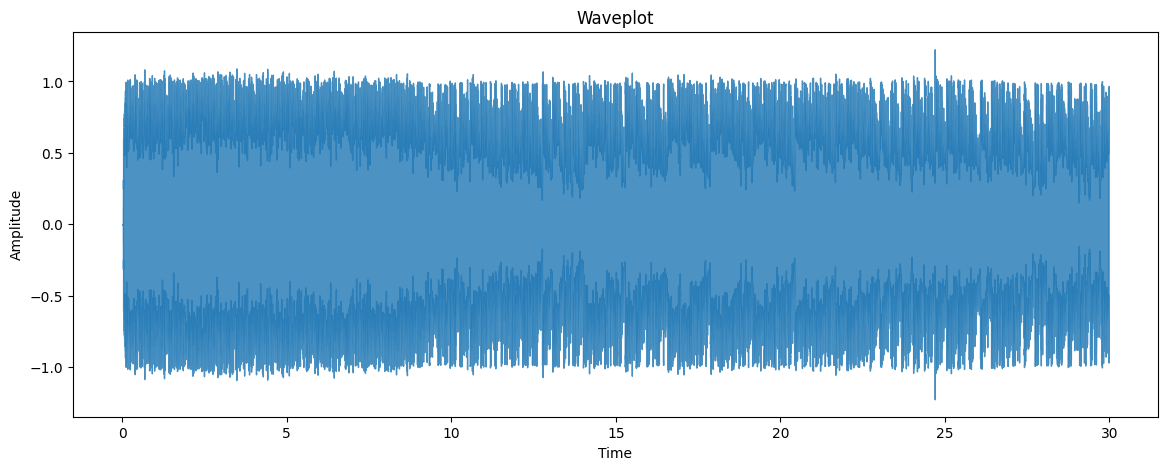

In [44]:
y, sr = load_song('rock', 25)
song_info(y, sr)
plot_waveplot(y, sr)

y: [-5.58793545e-09 -2.60770321e-08 -9.31322575e-09 ...  2.75511388e-03
 -1.08506605e-01  1.42986877e-02]
Duration: 29.98s, 660984 samples, 22.05 KHz


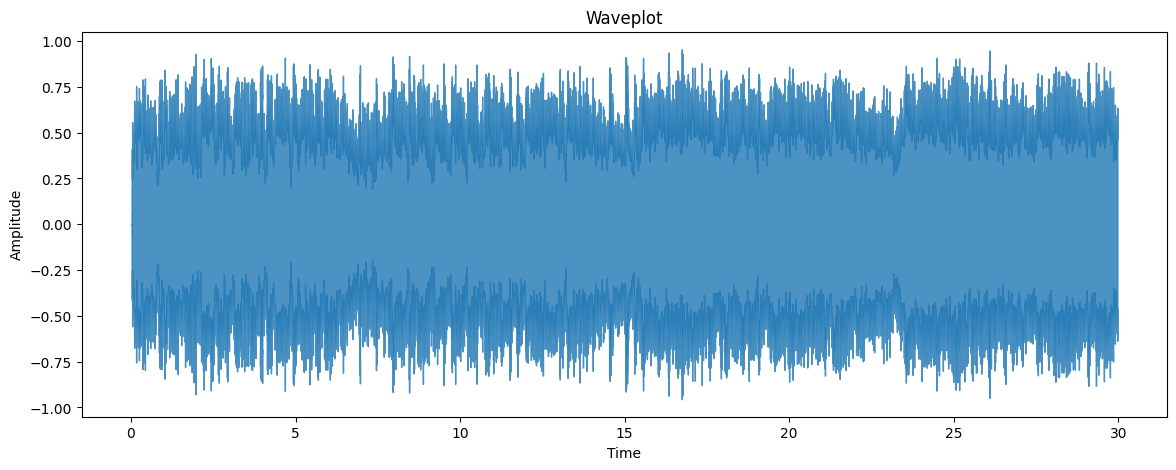

In [45]:
y2, sr2 = load_song('rock', 112)
song_info(y2, sr2)
plot_waveplot(y2, sr2)

y: [0.088508   0.14116132 0.13976398 ... 0.00157789 0.00309454 0.00263237]
Duration: 29.98s, 660984 samples, 22.05 KHz


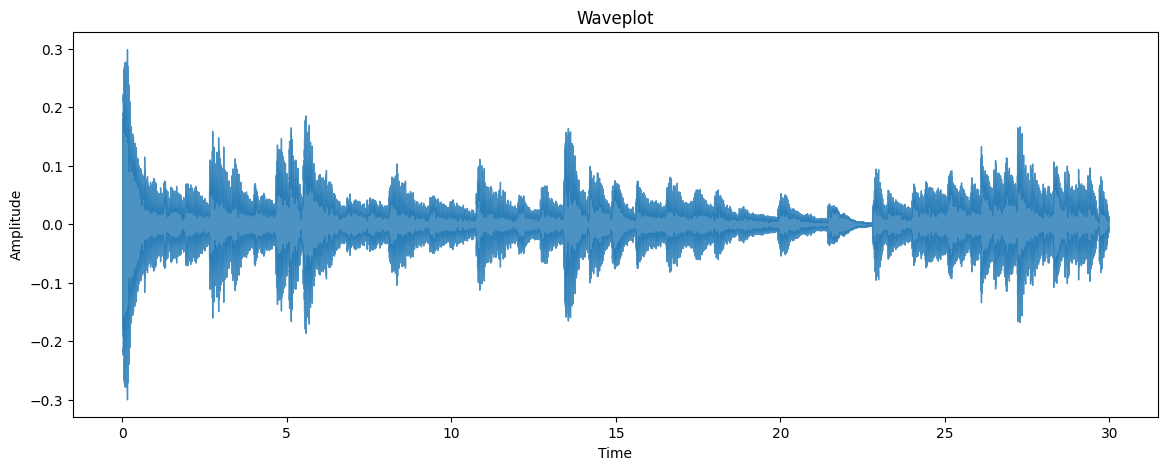

In [46]:
y3, sr3 = load_song('classical', 35)
song_info(y3, sr3)
plot_waveplot(y3, sr3)

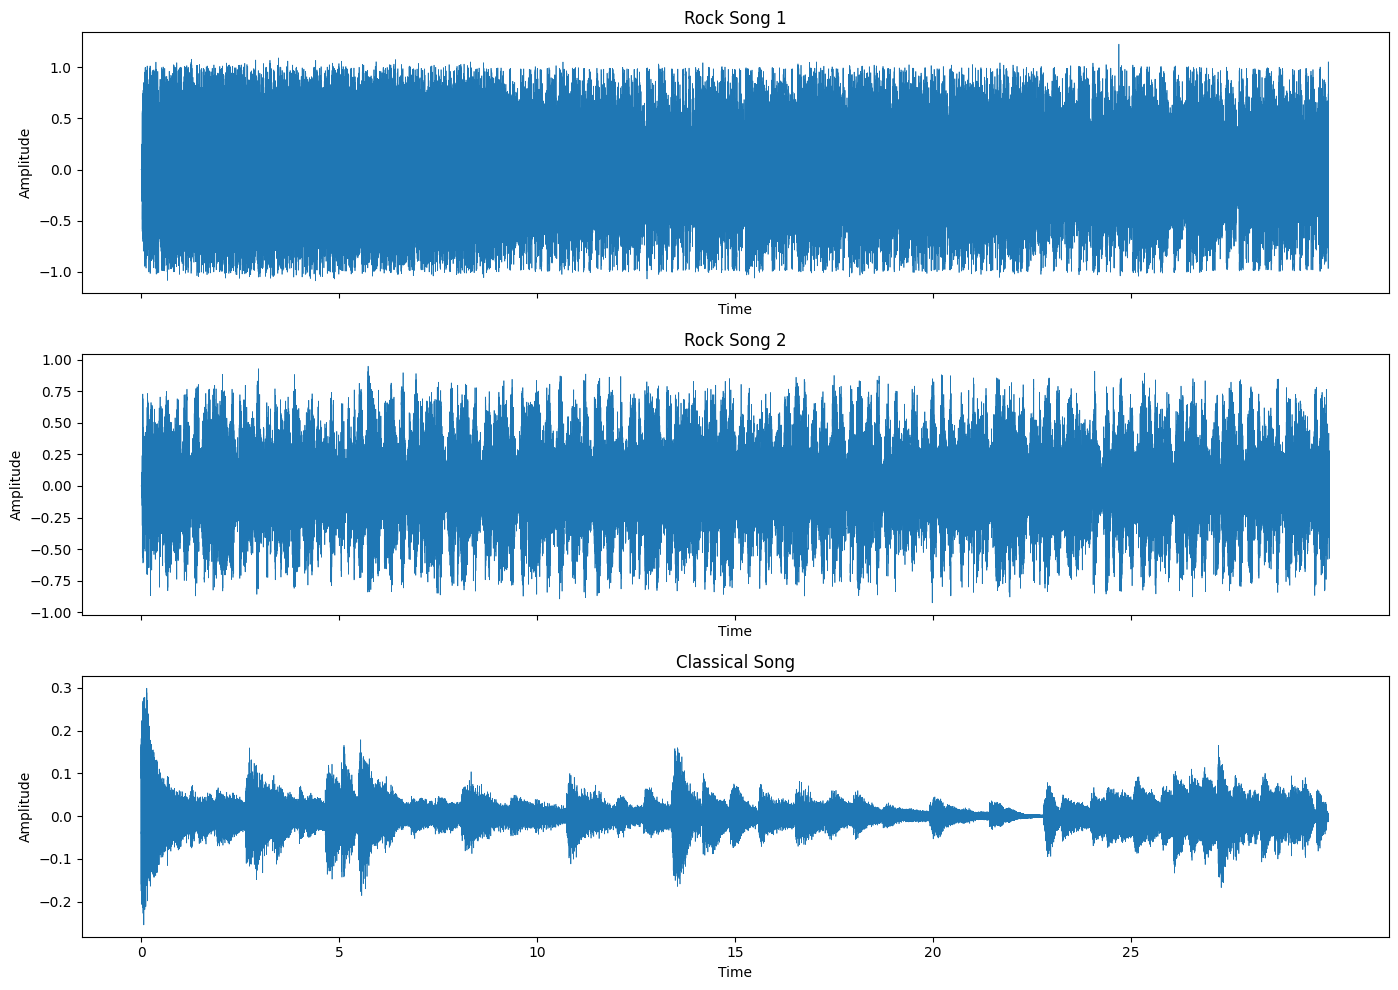

In [14]:
# plot the three songs together vertically

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(y, linewidth=0.5)
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

ax2.plot(y2, linewidth=0.5)
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

ax3.plot(y3, linewidth=0.5)
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels((x_ticks/sr).astype(int))

plt.tight_layout()
plt.show()

### Spettrogramma

È una tecnica di analisi molto comune utilizzata nell'elaborazione dei 
segnali audio per mostrare come l'energia del suono è distribuita nelle 
diverse frequenze durante un periodo di tempo specifico.
L'asse delle ascisse rappresenta il tempo mentre l'asse delle ordinate 
rappresenta la frequenza. Le frequenze più basse si trovano di solito 
nella parte inferiore dello spettrogramma, mentre le frequenze più alte 
si trovano nella parte superiore. La frequenza è solitamente misurata in
 unità come Hertz (Hz).

In [99]:
def spectrogram(y, mel=False):
    """
    Plot spectrogram of the song.

    :param y: Audio time series, i.e. the time series of the amplitude values
    :param mel: Mel-scaled spectrogram. If mel is true, plot both spectrogram and mel-scaled spectrogram in one figure vertically.
    :return:
    """

    # normalize the amplitude
    y = librosa.util.normalize(y)

    # Short-time Fourier transform (STFT)
    X = librosa.stft(y)

    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    x_db = librosa.amplitude_to_db(abs(X))

    # Display a spectrogram
    plt.figure(figsize=(14, 5))
    if mel:
        # Mel-scaled power spectrogram
        X_mel = librosa.feature.melspectrogram(y=y, sr=sr)
        x_db_mel = librosa.amplitude_to_db(abs(X_mel))

        plt.figure(figsize=(14, 10))

        plt.subplot(2, 1, 1)
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Simple Spectrogram')
        plt.colorbar()

        plt.subplot(2, 1, 2)
        librosa.display.specshow(x_db_mel, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Mel-scaled spectrogram')
        plt.colorbar()
        plt.tight_layout()
    else:
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Spectrogram')
        plt.colorbar()

    plt.show()

<Figure size 1400x500 with 0 Axes>

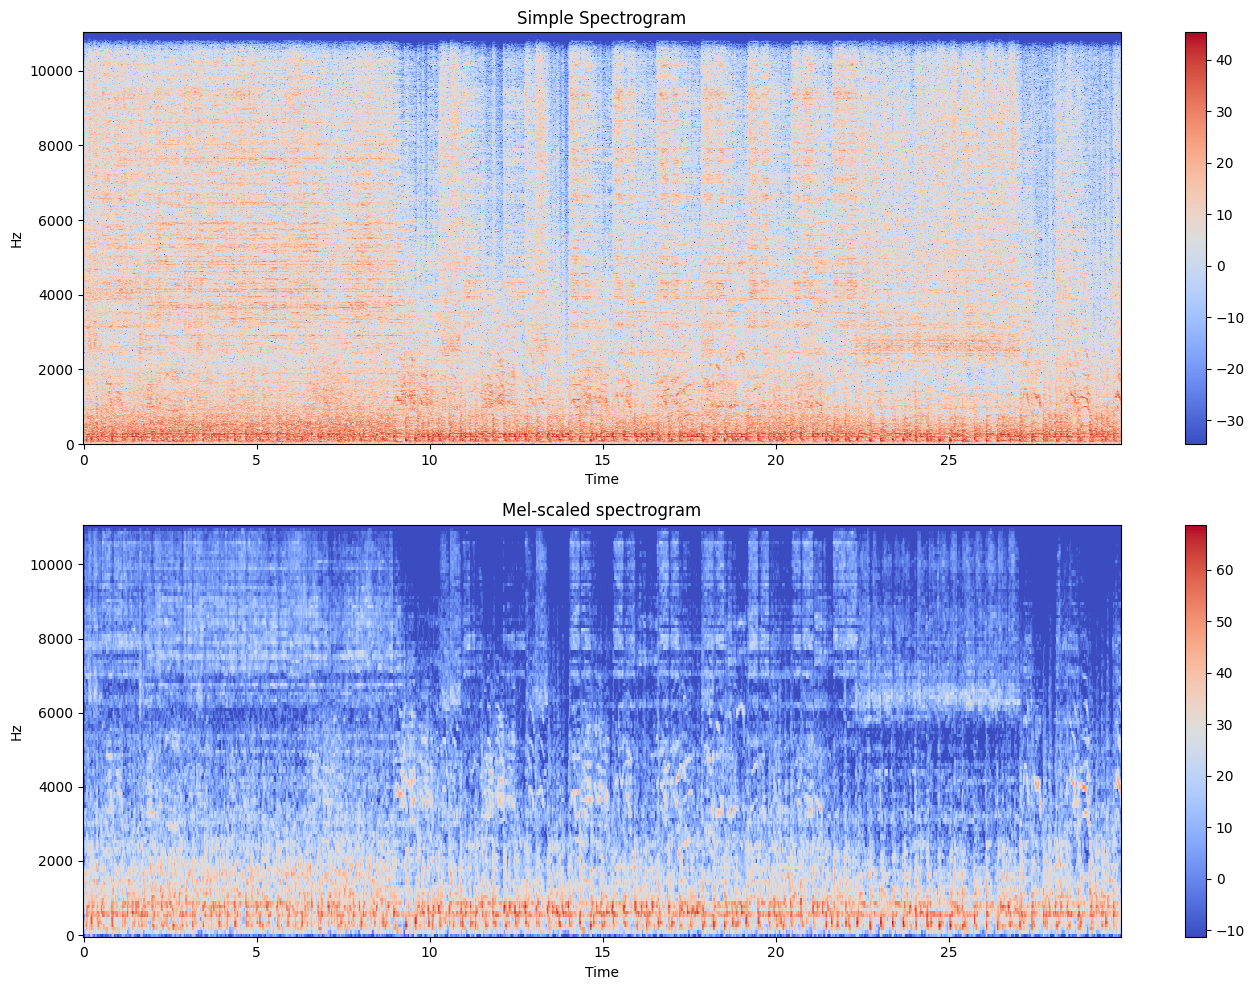

In [100]:
spectrogram(y, True)

## Possibili Features

### Zero Crossing Rate
Viene utilizzata per calcolare il tasso di attraversamento dello zero in
 un segnale audio. Il tasso di attraversamento dello zero rappresenta il
 numero di volte in cui la forma d'onda di un segnale attraversa l'asse 
orizzontale (zero) in un determinato intervallo di tempo.

In [15]:
def plot_zero_cross_rate(y1, y2, label1, label2, zero_line=True):

    # zero crossing rate
    z1 = librosa.feature.zero_crossing_rate(y1)
    z2 = librosa.feature.zero_crossing_rate(y2)


    # plot a graph with the two crossing rates, and one with the difference between the tww (horizontally)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    fig.suptitle('Zero Crossing Rate', fontsize=16)

    # left plot
    ax1.plot(z1[0], label=label1, linewidth=.5)
    ax1.plot(z2[0], label=label2, linewidth=.5)

    # mean line
    m1 = np.mean(z1)
    m2 = np.mean(z2)
    ax1.axhline(m1, color='blue', linestyle='--', linewidth=2, label=f'Mean of {label1}')
    ax1.axhline(m2, color='red', linestyle='--', linewidth=2, label=f'Mean of {label2}')

    # right plot
    z3 = z1 - z2
    ax2.plot(z3[0], color='green', label='Difference', linewidth=.5)
    ax2.set_title('Difference between the two crossing rates')

    # mean line
    m3 = np.mean(z3)
    ax2.axhline(m3, color='purple', linestyle='--', linewidth=2, label=f'Mean of the difference')

    if zero_line:
        ax1.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax1.set_title('Zero Crossing Rate')
        ax2.set_title('Zero Crossing Rate')

    ax1.legend()
    ax2.legend()

    plt.show()

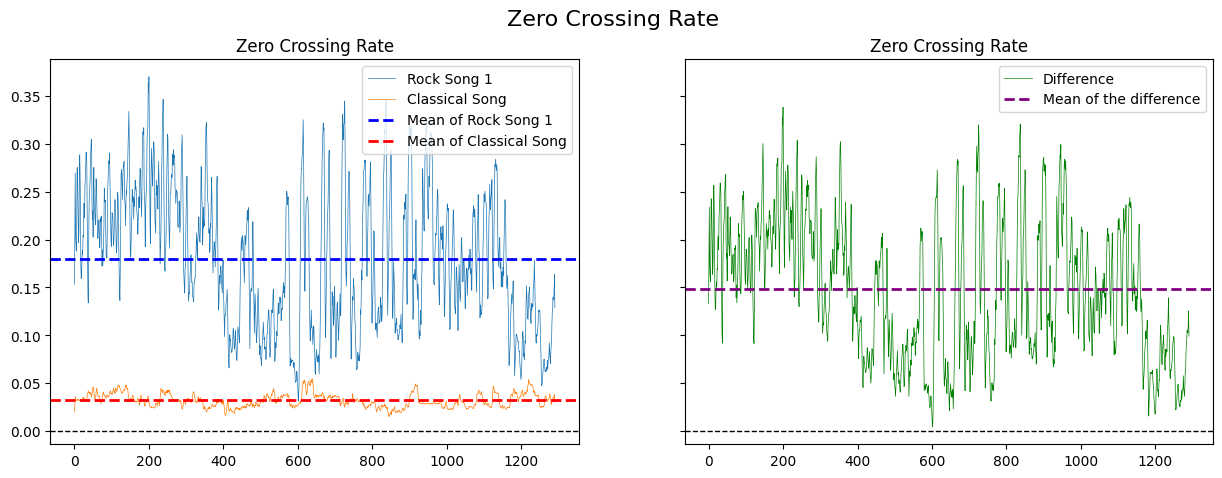

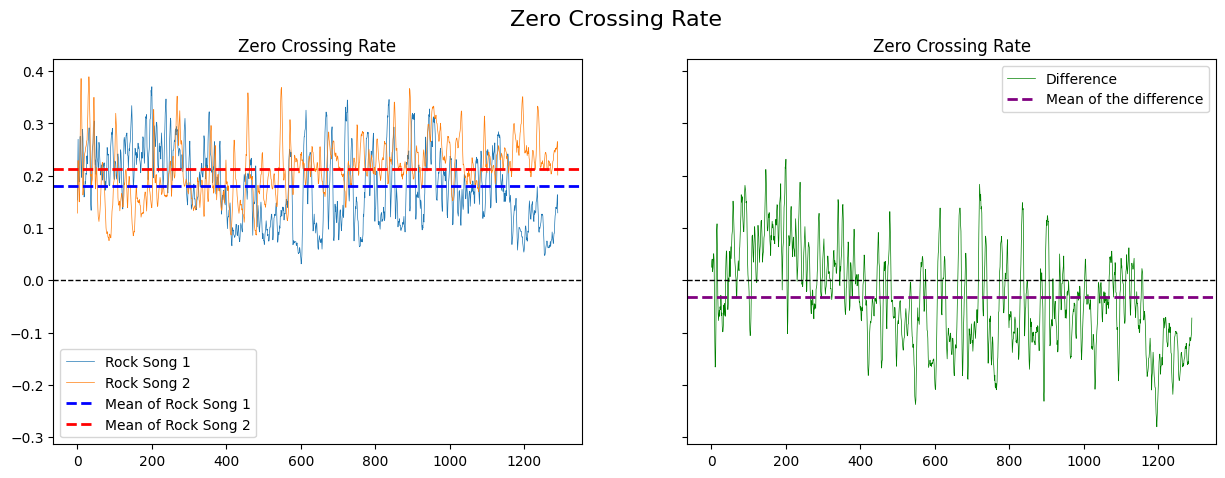

In [21]:
plot_zero_cross_rate(y, y3, 'Rock Song 1', 'Classical Song')
plot_zero_cross_rate(y, y2, 'Rock Song 1', 'Rock Song 2')

### RMS Energy
La ***Root Mean Square Energy*** è una misura dell'energia complessiva o della sonorità del segnale nel tempo. Fornisce informazioni sulle variazioni di ampiezza del segnale audio.

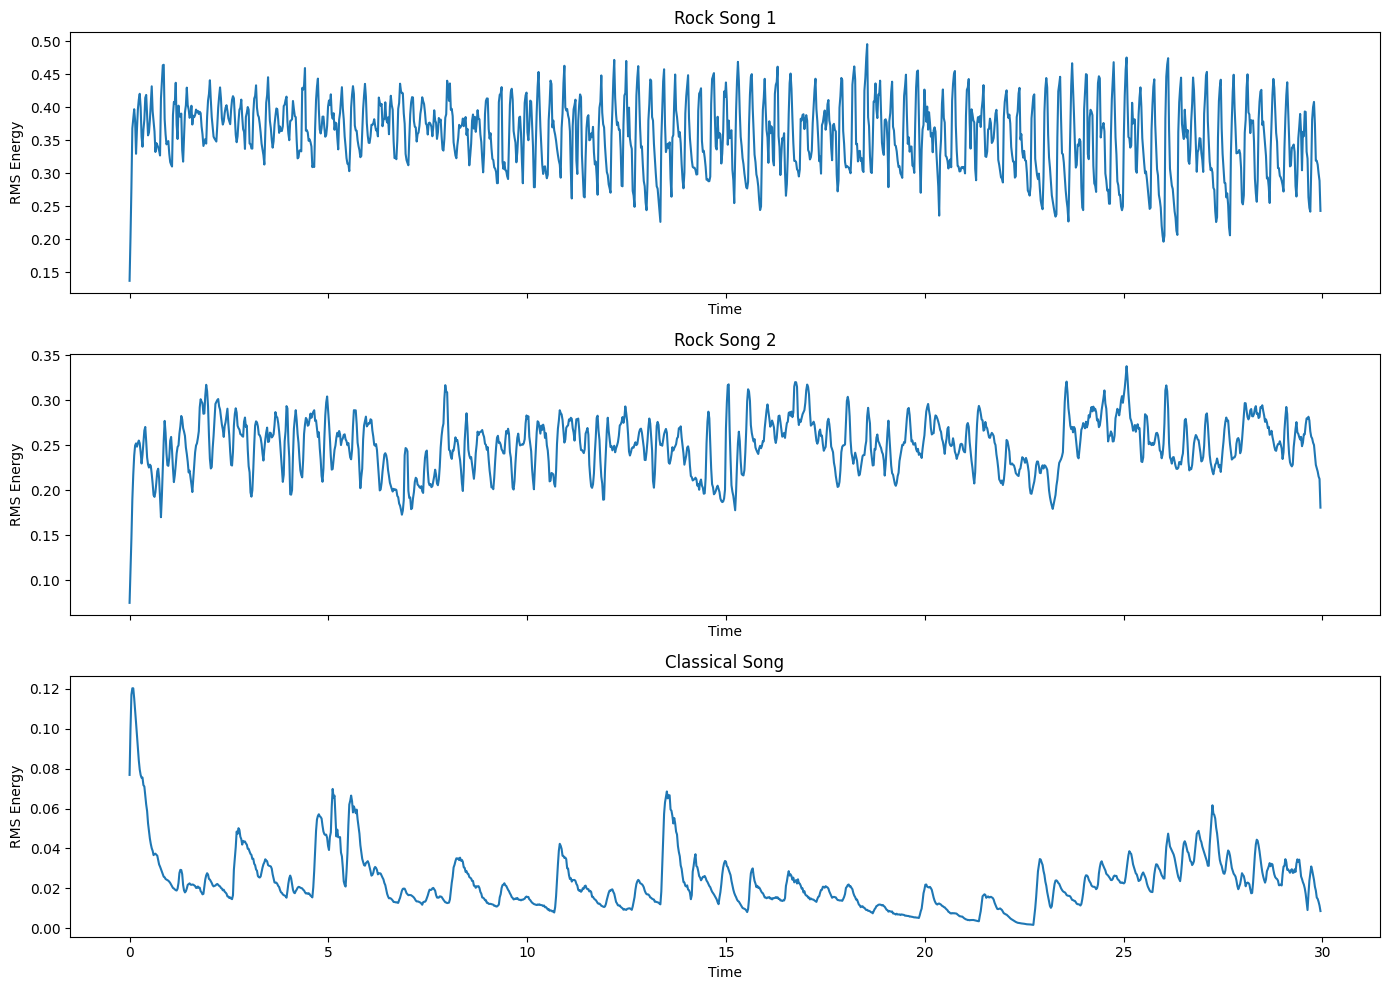

In [34]:
# Calculate RMS energy
rms1 = librosa.feature.rms(y=y)
rms2 = librosa.feature.rms(y=y2)
rms3 = librosa.feature.rms(y=y3)

times = librosa.times_like(rms)

# Plot RMS energy
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(times, rms1[0])
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMS Energy')

ax2.plot(times, rms2[0])
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('RMS Energy')

ax3.plot(times, rms3[0])
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('RMS Energy')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)

plt.tight_layout()
plt.show()

### Mel-Frequency Cepstral Coefficients
Sono una serie di coefficienti utilizzati per rappresentare le caratteristiche spettrali di un segnale audio in un formato compatibile con la percezione umana delle frequenze (vengono utilizzati soprettutto per il riconoscimento e la sintesi vocale).
Per essere più precisi, i coefficienti MFCC rappresentano una serie di valori numerici che catturano le caratteristiche spettrali del segnale audio in un dato frame temporale.
Ad esempio, nella cella (1,2) troveremo il valore del terzo coefficiente di mel nel secondo frame.

In [41]:
def plot_mfcc(*Y, sr, songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)
    fig.suptitle('Mel-frequency cepstral coefficients (MFCC)', fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):

        # mfcc of the song
        mfcc = librosa.feature.mfcc(y=Y[i], sr=sr)

        mean = np.mean(mfcc)
        variance = np.var(mfcc)

        # scale the mfcc
        mfcc = skl.preprocessing.scale(mfcc, axis=1)

        # display the mfcc
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax[i])

        # set title
        title = songs_names[i] if songs_names else f'Song {i+1}'
        ax[i].set_title(f'{title}\nMean: {mean:.2f}, Variance: {variance:.2f}')

        # set x and y labels
        ax[i].set_xlabel(None)
        ax[i].set_ylabel('MFCC')

    ax[-1].set_xlabel('Time')

    plt.show()

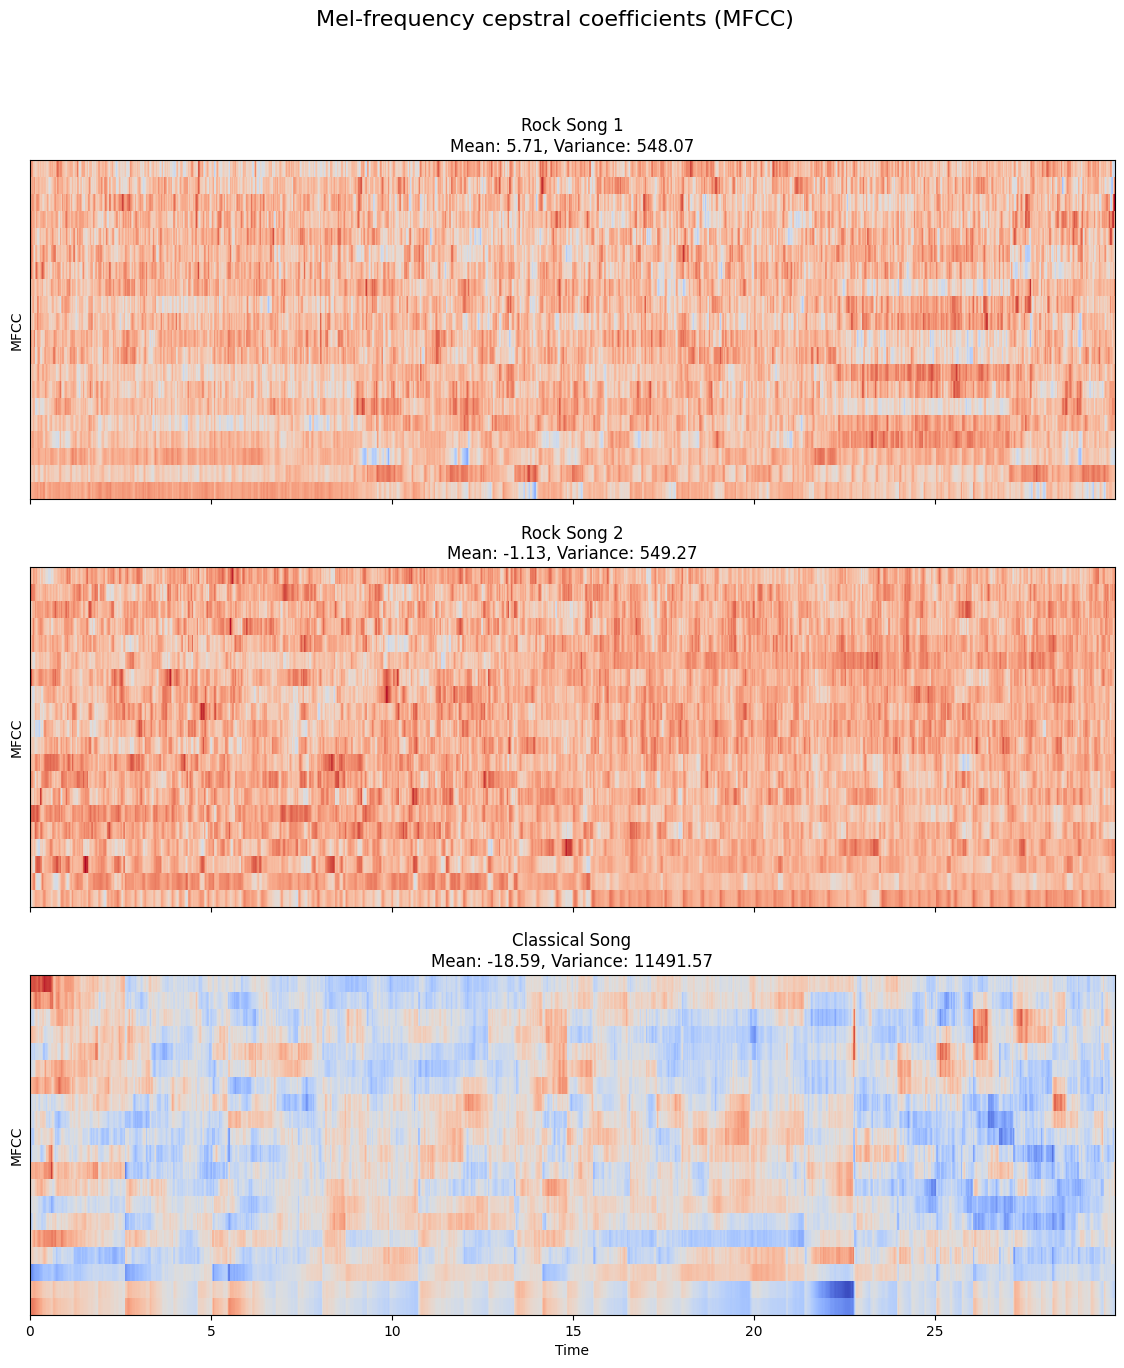

In [42]:
plot_mfcc(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Spectral centroid
è una misura del 'centro di massa' dello spettro. Indica dove si trova 
il 'centro' del suono in termini di frequenza. Percettivamente, è 
strettamente correlato alla sensazione di 'brillantezza' di un suono.

In [48]:
def normalize(x, axis=0):

    return skl.preprocessing.minmax_scale(x, axis=axis)

def plot_spectral_centroid(*Y, sr, title='Spectral Centroid', xlabel='Time', ylabel='Frequency', songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)

    fig.suptitle(title, fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):
        y = Y[i]

        # Computing the spectral centroid for each frame
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

        # Computing the time variable for visualization
        frames = range(len(cent))

        # Converts frame counts to time (seconds)
        t = librosa.frames_to_time(frames)

        librosa.display.waveshow(y, sr=sr, linewidth=.5,  alpha=0.4, ax=ax[i])
        ax[i].plot(t, normalize(cent), color='#FFB100', label='Spectral Centroid', linewidth=2)

        title = songs_names[i] if songs_names else f'Song {i+1}'

        ax[i].set_title(title)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

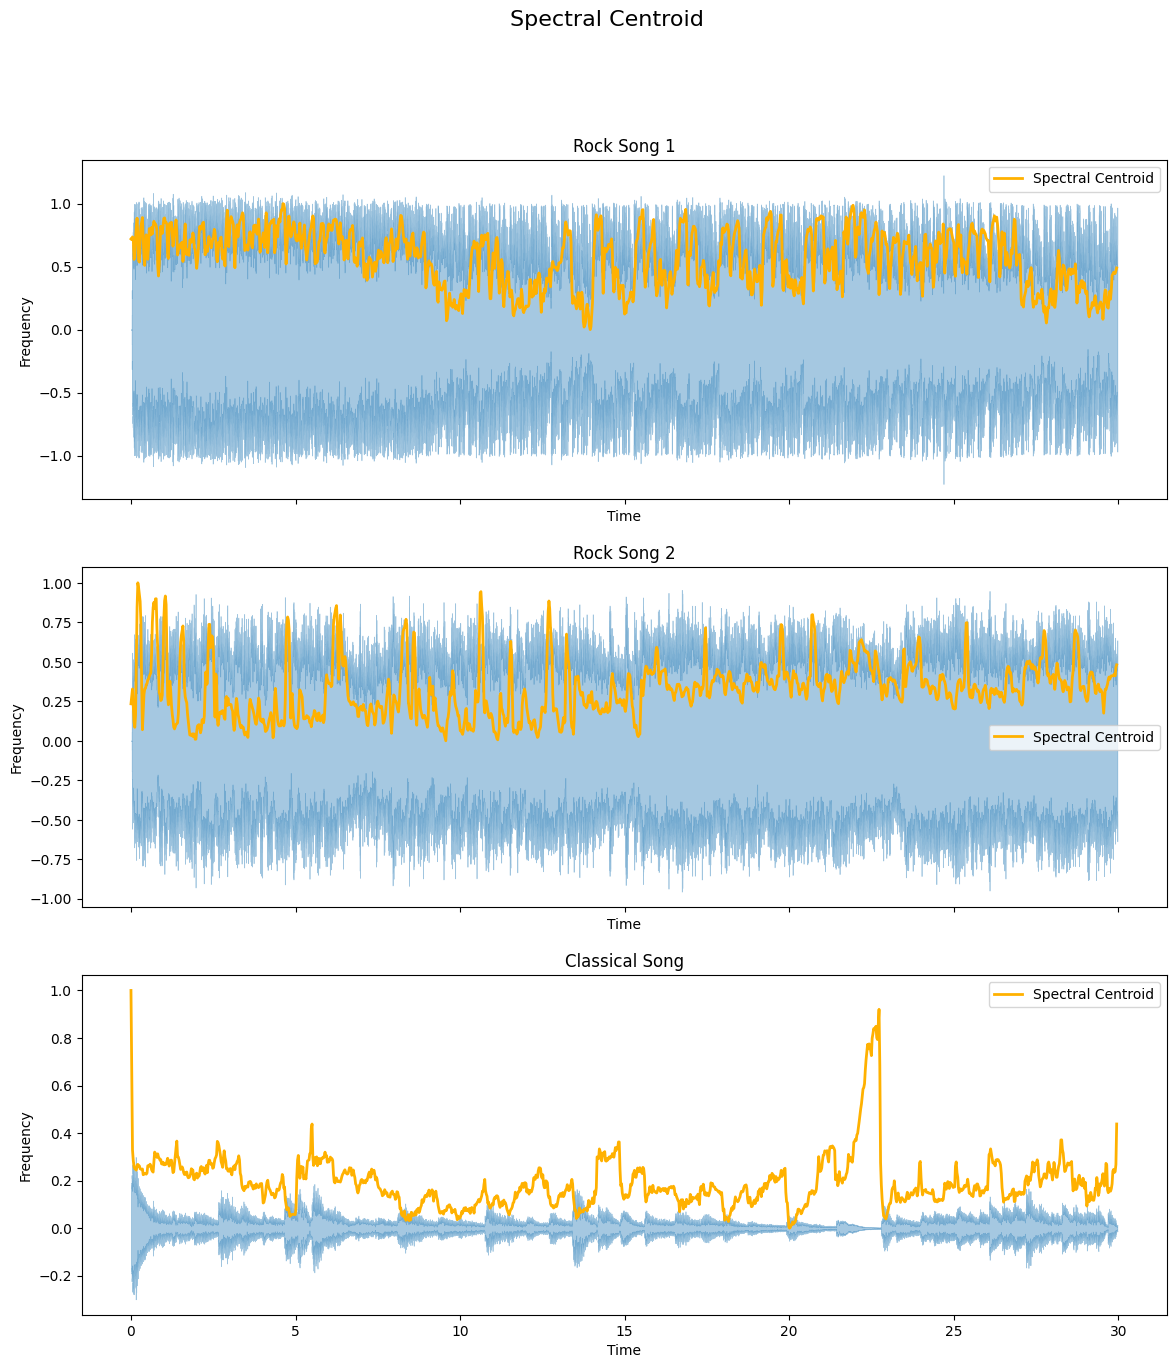

In [49]:
plot_spectral_centroid(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Chroma Features
Le Chroma Features, sono strumenti utili ad analizzare il contenuto armonico e tonale della musica. Sono particolarmente utili per compiti che coinvolgono 
l'analisi del tono e dell'armonia, come il riconoscimento degli accordi, il rilevamento della tonalità e la stima della somiglianza musicale.

Le Chroma features rappresentano l'intensità di ciascuna delle 12 classi di tonalità (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) nel segnale audio, indipendentemente dall'ottava. Questo le rende particolarmente adatte per l'analisi delle caratteristiche armoniche e melodiche della musica.

Concetti chiave:

- **classe di tonalità**: tutte le tonalità che condividono la stessa nota (ad esempio, tutte le note C nelle diverse ottave);
- **"Invarianza d'ottava**: le caratteristiche sommano l'energia su tutte le ottave per ciascuna classe di note.

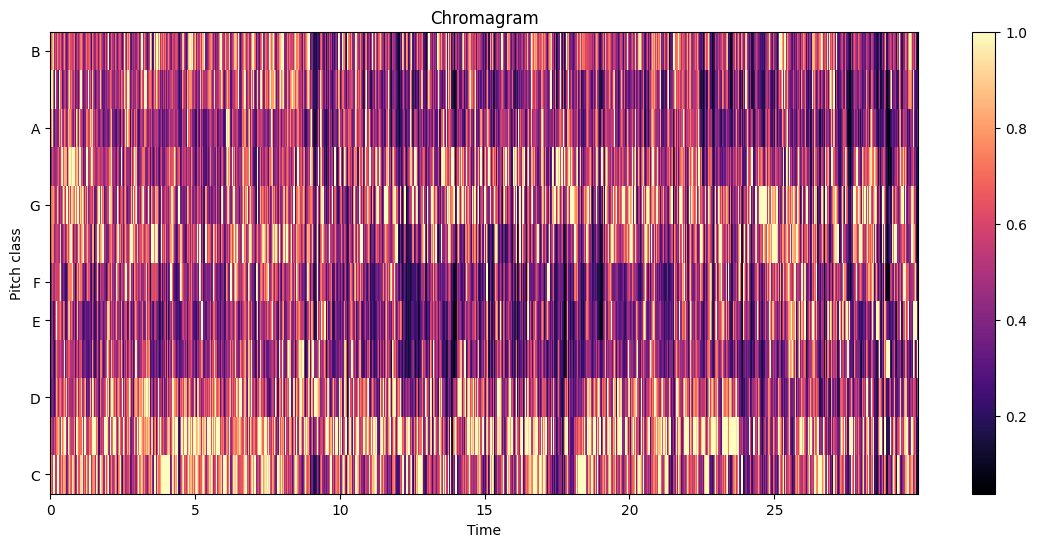

In [47]:
# Compute chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Visualize chroma features
plt.figure(figsize=(14, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()

## Dataset and features manipulation

### Load features and metadata 

In [56]:
# Load metadata and features.    
X = utils.load('./fma_metadata/features_medium.csv')
y = pd.read_csv('./fma_metadata/train_labels.csv', index_col=0)

# flattening
X.columns = X.columns.map('-'.join).str.strip('-')

np.testing.assert_array_equal(X.index, y.index)

X

chroma_cens-kurtosis-01  chroma_cens-kurtosis-02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
134                      0.918445                 0.674147   
...                           ...                      ...   
155297                  -0.007668                 0.104604   
155298                  -0.956019                -0.961210   
155306                   0.644815                -0.879404   
155307                  -0.446937                 1.235004   
155314                  -0.121936                -0.348523   

          chroma_cens-kurtosis-03  chroma_cens-kurtosis-04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
134                      0.577818                 1.281117   
...                           ...                      ...   
155297                  -0.511487                 0.857308   
155298                  -0.447053                -0.689531   
155306                  -1.149232                -0.655986   
155307                  -0.250855                -0.612224   
155314                  -0.555810                -0.607600   

          chroma_cens-kurtosis-05  chroma_cens-kurtosis-06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
134                      0.933746                 0.078177   
...                           ...                      ...   
155297                   0.266202                -0.355186   
155298                  -0.633071                -0.430116   
155306                  -0.848881                -0.672240   
155307                  -1.197387                -1.118230   
155314                  -0.823013                -0.369621   

          chroma_cens-kurtosis-07  chroma_cens-kurtosis-08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
134                      1.199204                -0.175223   
...                           ...                      ...   
155297                  -0.273640                -0.324727   
155298                  -0.031147                -0.758652   
155306                   0.193149                 0.069103   
155307                   0.716520                -0.878211   
155314                  -0.573967                 0.554874   

          chroma_cens-kurtosis-09  chroma_cens-kurtosis-10  ...  \
track_id                                                    ...   
2                        0.866868                 1.341231  ...   
3                        0.108103                 0.619185  ...   
5                        0.666617                 1.038546  ...   
10                       0.521217                 1.982386  ...   
134                      0.925482                 1.438509  ...   
...                           ...                      ...  ...   
155297                  -0.106368                -1.146157  ...   
155298                  -1.093452                 0.083694  ...   
155306                  -0.179058                -0.713318  ...   
155307                  -0.637801            

In [57]:
# Data cleaning
X = X.drop(utils.FILES_TRAIN_FAULTY)
y = y.drop(utils.FILES_TRAIN_FAULTY)

# The track IDs are integers for the training set.
X.index = pd.Index((int(i) for i in X.index), name='track_id')

# Should be done already, but better be sure.
X.sort_index(inplace=True)
y.sort_index(inplace=True)

assert (X.index == y.index).all()

scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X)

array([[ 4.529576  ,  3.33097238,  0.00486157, ..., -0.53177061,
        -0.37855813,  0.83556346],
       [ 1.1173973 ,  0.45147752,  0.02529187, ..., -0.53177061,
        -0.50991705,  1.14464415],
       [ 0.23954127, -0.08849978, -0.10773166, ..., -0.53177061,
        -0.34214745,  0.18511403],
       ...,
       [ 0.31514755, -0.60499943, -0.29284746, ...,  0.47560839,
         0.00487408, -0.71042468],
       [-0.38883455,  0.75713492, -0.10161046, ..., -0.12881901,
        -0.41157396,  0.11598227],
       [-0.17926795, -0.2629976 , -0.16652615, ...,  0.77782209,
        -0.41403999, -0.81765594]])

In [7]:
CATEGORIES = sorted(y["genre"].unique())

y.groupby('genre').size()

genre
blues                    74
classical               619
country                 178
easy listening           21
electronic             6311
experimental           2250
folk                   1518
hip-hop                2192
instrumental           1349
international          1018
jazz                    384
old-time / historic     510
pop                    1186
rock                   7097
soul-rnb                154
spoken                  118
dtype: int64

In [8]:
CATEGORIES

['blues',
 'classical',
 'country',
 'easy listening',
 'electronic',
 'experimental',
 'folk',
 'hip-hop',
 'instrumental',
 'international',
 'jazz',
 'old-time / historic',
 'pop',
 'rock',
 'soul-rnb',
 'spoken']

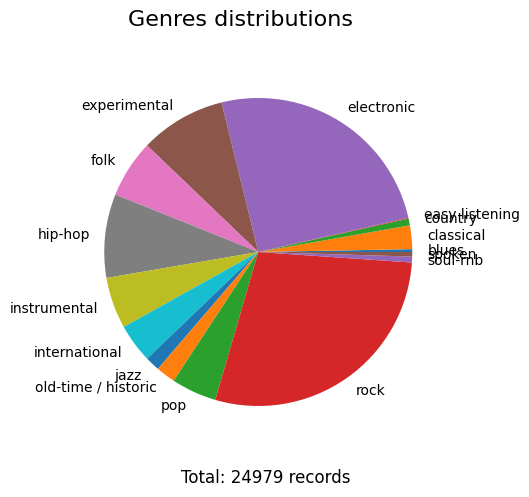

In [9]:
# plot a pie chart of genres
fig, ax = plt.subplots(1, 1, figsize=(14, 5), facecolor='white')
fig.suptitle('Genres distributions', fontsize=16)

# plot a bar chart of genres
ax.pie(y.groupby('genre').size(), labels=CATEGORIES)
ax.text(-.5, -1.5, 'Total: {} records'.format(len(y)), fontsize=12)

plt.show()

## Analisi sui dati

In [10]:
def compute_correlation_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # compute the correlation matrix
    corr = df.corr()

    return corr

# plot correlation matrix
def plot_correlation_matrix(df: pd.DataFrame, title: str = 'Correlation Matrix'):

    # compute the correlation matrix
    corr = compute_correlation_matrix(df)

    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    plt.subplots(figsize=(14, 10))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,  cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(title)
    plt.show()


## matrici correlazione

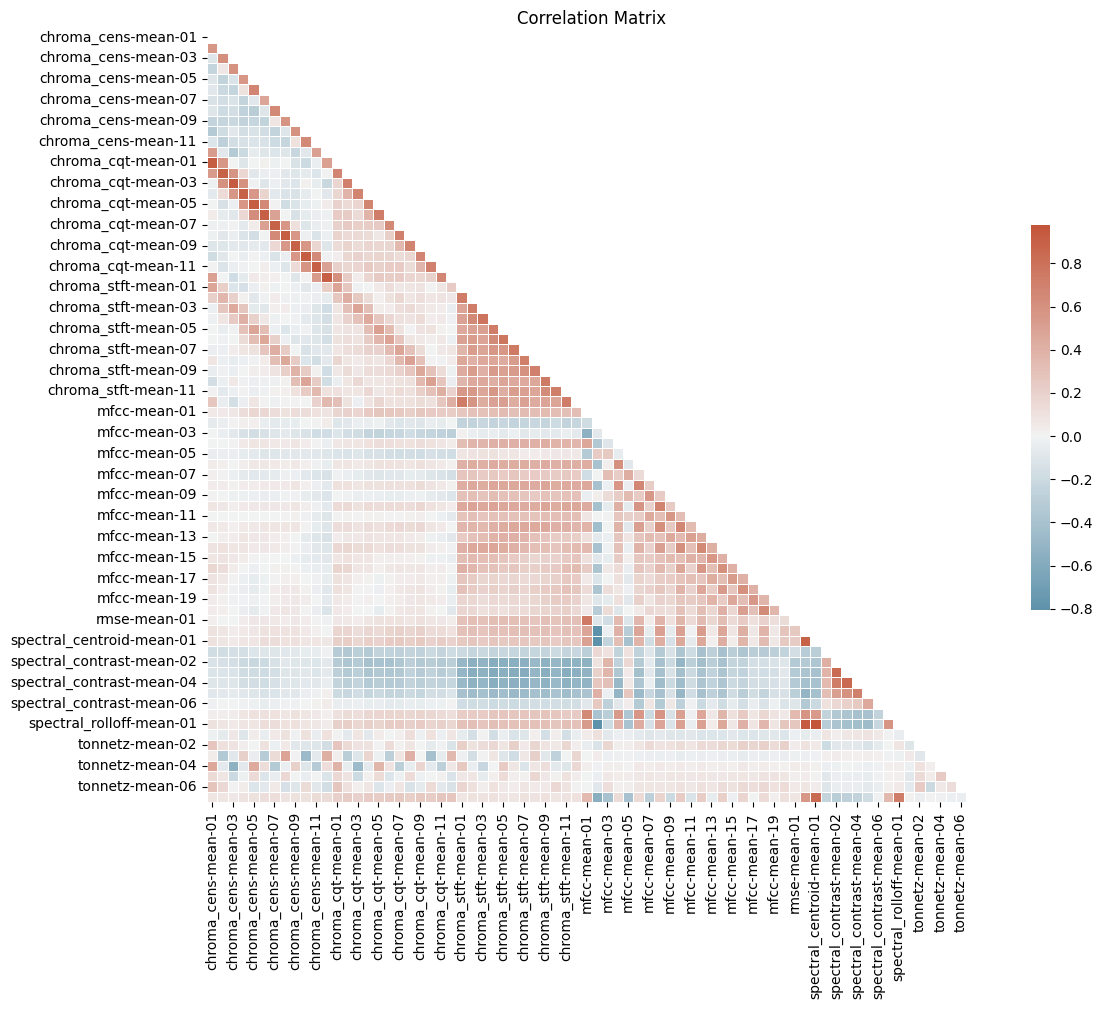

In [11]:
feat = [col for col in X.columns if 'mean' in col]
plot_correlation_matrix(X[feat], title='Correlation Matrix')

## PCA

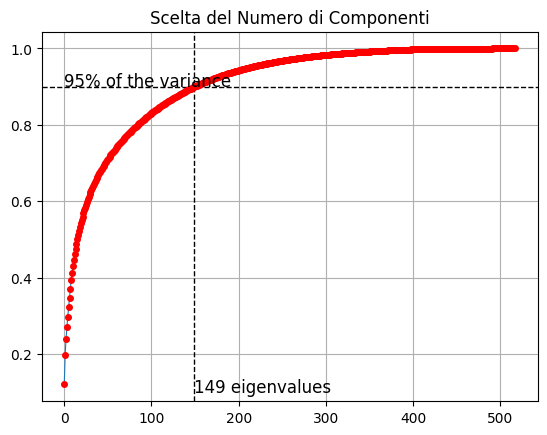

In [38]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)  # PCA senza specificare componenti
cumsum = np.cumsum(pca.explained_variance_ratio_)
idx = np.argmin(np.abs(cumsum - cumsum[-1]*.90))

# plot the eigenvalues horizontal line that represents the 95% of the variance
plt.axhline(cumsum[idx], color='black', linestyle='--', linewidth=1)
plt.text(0, cumsum[idx], '95% of the variance', fontsize=12)

# plot the eigenvalues vertical line that represents the number of eigenvalues that represents the 95% of the variance
plt.axvline(idx, color='black', linestyle='--', linewidth=1)
plt.text(idx, 0.1, f'{idx} eigenvalues', fontsize=12)

plt.plot(cumsum, linewidth=.8, marker='o', markersize=4, markerfacecolor='red', markeredgecolor='red')

plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()


In [17]:
def plot_eigenvalues(y: pd.DataFrame, title: str = 'Eigenvalues'):
    https://dnsleaktest.com/results.html"""
    Plot the eigenvalues of the correlation matrix of the dataset.
    :param y: Dataset
    :param title: Title of the plot
    :return:
    """

    # compute the correlation matrix
    corr = compute_correlation_matrix(y)

    # compute the eigenvalues
    eig_vals = np.linalg.eigvals(corr)

    # sort the eigenvalues
    eig_vals = np.sort(eig_vals)[::-1]

    # plot the eigenvalues
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title, fontsize=16)

    ax1.plot(eig_vals, linewidth=.8, marker='o', markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax1.set_title('Eigenvalues - Sorted')

    # compute the cumulative sum of the eigenvalues
    cumsum = np.cumsum(eig_vals)

    # find the point on cumsum line that is closest to the 95% of the variance
    idx = np.argmin(np.abs(cumsum - cumsum[-1]*.95))

    # plot the eigenvalues horizontal line that represents the 95% of the variance
    ax2.axhline(cumsum[idx], color='black', linestyle='--', linewidth=1)
    ax2.text(0, cumsum[idx]+.3, '95% of the variance', fontsize=12)

    # plot the eigenvalues vertical line that represents the number of eigenvalues that represents the 95% of the variance
    ax2.axvline(idx, color='black', linestyle='--', linewidth=1)
    ax2.text(idx+1, 5, f'{idx} eigenvalues', fontsize=12)

    # plot the cumulative sum of the eigenvalues
    ax2.plot(cumsum, linewidth=.8, marker='o', markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax2.set_title('Cumulative Sum of the Eigenvalues')

    plt.show()

In [23]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)  # PCA senza specificare componenti

# compute the correlation matrix
corr = compute_correlation_matrix(X)

# compute the eigenvalues
eig_vals = np.linalg.eigvals(corr)

# sort the eigenvalues
eig_vals = np.sort(eig_vals)[::-1]

eig_vals2 = np.sort(pca.explained_variance_ratio_)[::-1]



### Dataset selection and train-test splitting

In [62]:
from sklearn.model_selection import train_test_split

def split_dataset(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.3, random_state: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train, test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return train, test, y_train, y_test

In [63]:
X_train, X_test, y_train, y_test = split_dataset(X,y,test_size=0.2,random_state=42)
X_test, X_val, y_test, y_val = split_dataset(X_test,y_test,test_size=0.5,random_state=42)

print('{} training examples, {} testing examples, {} validation example'.format(y_train.size, y_test.size, y_val.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))
X_val.values

19983 training examples, 2498 testing examples, 2498 validation example
518 features, 16 classes


array([[-0.20245295, -0.13815152, -0.11042559, ..., -0.53177061,
         0.60425723,  0.71548404],
       [-0.61623144, -0.63465081, -0.10786262, ...,  1.28151159,
        -0.42181528, -0.73606511],
       [ 0.74989012,  0.59437621,  0.1901723 , ..., -0.53177061,
         0.93482735, -0.28917432],
       ...,
       [ 0.52625628,  0.90559071,  0.29968177, ...,  0.07265679,
         0.16217654, -0.00314237],
       [ 1.17343102,  1.10477795,  0.23282947, ...,  1.08003579,
         1.49234957, -0.35953915],
       [-0.13776182, -0.41247916, -0.18933592, ..., -0.53177061,
        -0.43401319,  0.28512388]])

In [81]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

print("Forma originale:", X_train.shape)
percent = [.90, .75]

X_trains = []
X_tests = []

X_trains.append(X_train)
X_tests.append(X_test)

pca_full = PCA().fit(X)  # PCA senza specificare componenti
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

for p in percent:
    d = np.argmin(np.abs(cumsum - cumsum[-1]*p))
    pca = PCA(n_components=d)
    X_trains.append(pd.DataFrame(pca.fit_transform(X_train)))
    X_tests.append(pd.DataFrame(pca.fit_transform(X_test)))



Forma originale: (19983, 518)
[       chroma_cens-kurtosis-01  chroma_cens-kurtosis-02  \
24317                 0.221563                 0.688121   
10379                -0.009838                 0.513620   
11530                -0.384100                -0.316385   
8030                 -0.343549                -0.496688   
22431                 0.887559                 1.041049   
...                        ...                      ...   
4339                  0.625409                 0.819223   
4473                  0.062794                 0.373581   
9964                 -0.494504                -0.554956   
23945                -0.297114                -0.159565   
11802                 0.682625                 0.167342   

       chroma_cens-kurtosis-03  chroma_cens-kurtosis-04  \
24317                 0.044435                 0.205462   
10379                -0.074276                 0.254428   
11530                -0.171958                -0.175340   
8030                 -0.

In [83]:
def train_model(model, X_trains, X_tests, y_train, y_test):
    for i in range(len(X_trains)):
        model.fit(X_trains[i],y_train)
    

# Models

## Gaussian Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()

gnb_clf.fit(X_train,y_train)

GaussianNB()

In [80]:
valuate(gnb_clf, X_test, y_test)

NameError: name 'gnb_clf' is not defined

### SVM Classifier

In [90]:
from sklearn.svm import SVC

def svm(X_train, y_train, X_test, y_test, title: str = 'SVM'):

    # create the model
    model = SVC(kernel="rbf",gamma='scale')

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)
    

# svm_clf = 

# train_model(svm_clf, X_trains, X_tests, y_train, y_test)

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.81      0.90      0.85        77
            country       0.00      0.00      0.00        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.65      0.82      0.73       606
       experimental       0.51      0.53      0.52       226
               folk       0.61      0.66      0.63       152
            hip-hop       0.72      0.60      0.66       223
       instrumental       0.54      0.41      0.46       137
      international       0.70      0.42      0.53       104
               jazz       0.68      0.41      0.52        41
old-time / historic       0.98      0.96      0.97        45
                pop       0.41      0.06      0.10       126
               rock       0.74      0.86      0.79       699
           soul-rnb       0.00      0.00      0.00        19
             spoken    

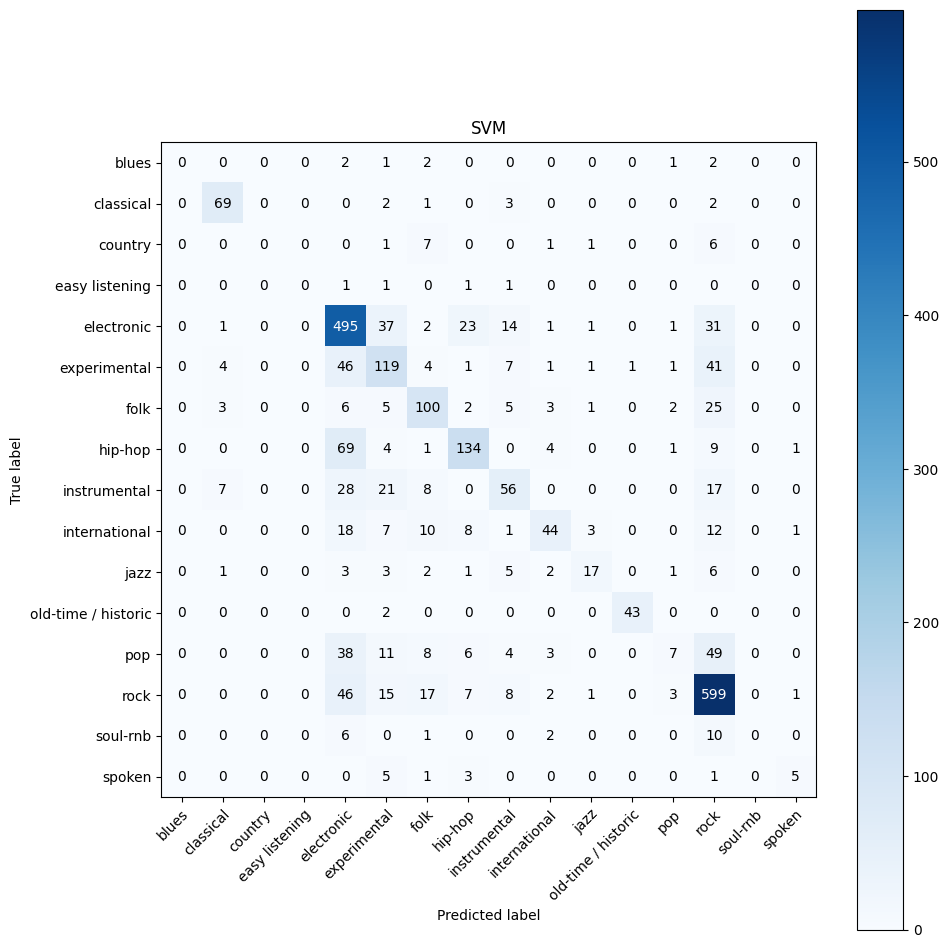

In [91]:
svm(X_trains[0], y_train, X_tests[0], y_test)

In [ ]:
svm(X_trains[1], y_train, X_tests[1], y_test)

In [20]:
from sklearn.svm import SVC

def svm(
        X_train, y_train, X_test, y_test,
        title: str = 'SVM',
        kernel: str = 'rbf',
        degree: int = 3,
        C: float = 1.0,
        gamma: Union[float, str] = 'scale',
        valuate: bool = True
    ):
    # create the model
    model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, max_iter=1000)

    # train the model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    if valuate:
        # plot the confusion matrix
        plot_confusion_matrix(y_test, y_pred, title, CATEGORIES)

        # print the scores
        print_scores(y_test, y_pred)

    return model

[1.00000000e-02 1.58489319e-01 2.51188643e+00 3.98107171e+01
 6.30957344e+02 1.00000000e+04 1.58489319e+05 2.51188643e+06
 3.98107171e+07 6.30957344e+08 1.00000000e+10]


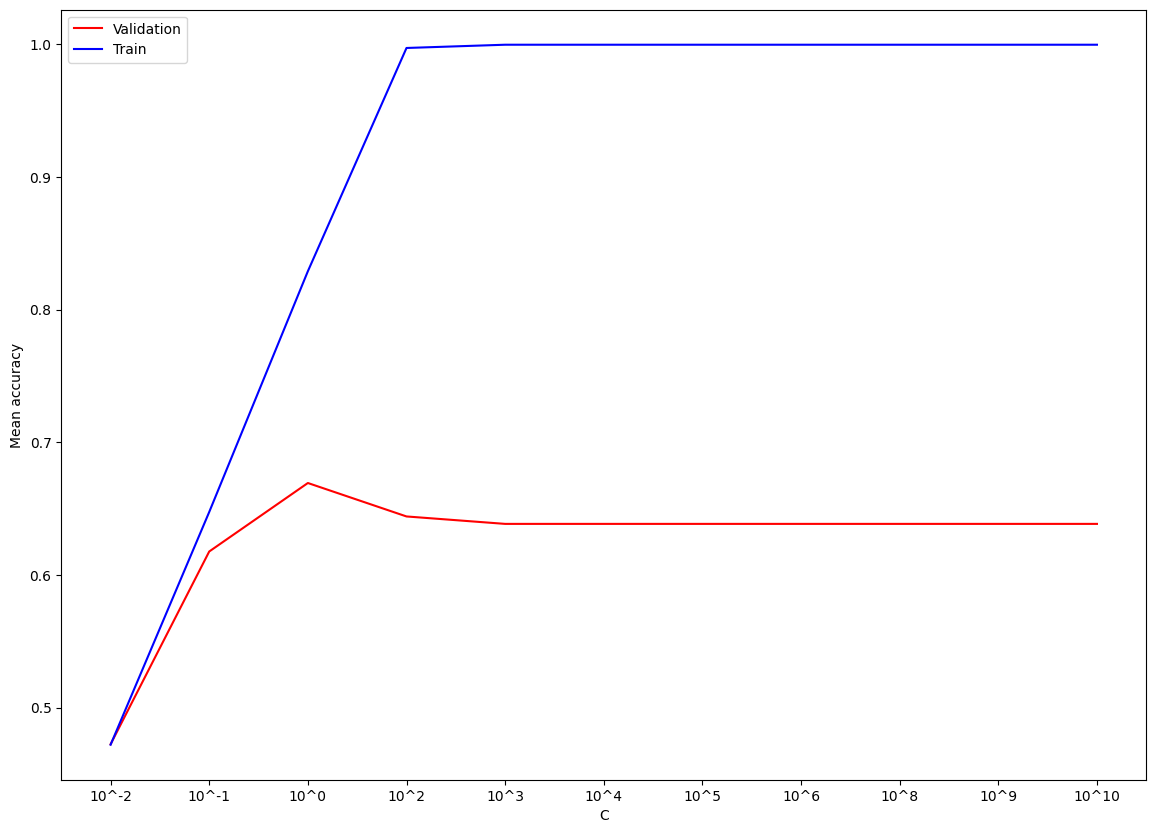

In [21]:
# hyperparameter C tuning
c_range = np.logspace(-2, 10, 11)
print(c_range)

c_results = []
for c in c_range:
    model = svm(X_train, y_train, X_val, y_val, valuate=False, C=c)
    c_results.append({
        'c': c,
        'score': model.score(X_val.values, y_val.values),
        'score_train': model.score(X_train.values, y_train.values)
    })

plt.figure(figsize=(14, 10))
plt.plot(list(map(lambda x: x['score'], c_results)), label='Validation', color='red')
plt.plot(list(map(lambda x: x['score_train'], c_results)), label='Train', color='blue')
plt.legend()
# plt.xticks(ticks=range(len(c_range)), labels=[f"{c:.2f}" for c in c_range])
plt.xticks(ticks=range(len(c_range)), labels=[f"10^{np.log10(c):.0f}" for c in c_range])
plt.ylabel('Mean accuracy')
plt.xlabel('C')
plt.show()


### DecTree, Bagging, Boosting

In [36]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from six.moves import xrange
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

In [39]:
maxdepth=8
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxdepth, splitter='best')

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))


Accuracy: 52.52%


                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        13
          classical       0.52      0.37      0.43        92
            country       0.00      0.00      0.00        29
     easy listening       0.00      0.00      0.00         4
         electronic       0.52      0.68      0.59       977
       experimental       0.27      0.22      0.25       363
               folk       0.46      0.54      0.50       218
            hip-hop       0.41      0.32      0.36       329
       instrumental       0.31      0.27      0.29       208
      international       0.62      0.14      0.23       144
               jazz       0.20      0.02      0.03        55
old-time / historic       0.85      0.67      0.75        70
                pop       0.00      0.00      0.00       149
               rock       0.62      0.79      0.70      1046
           soul-rnb       0.00      0.00      0.00        29
             spoken    

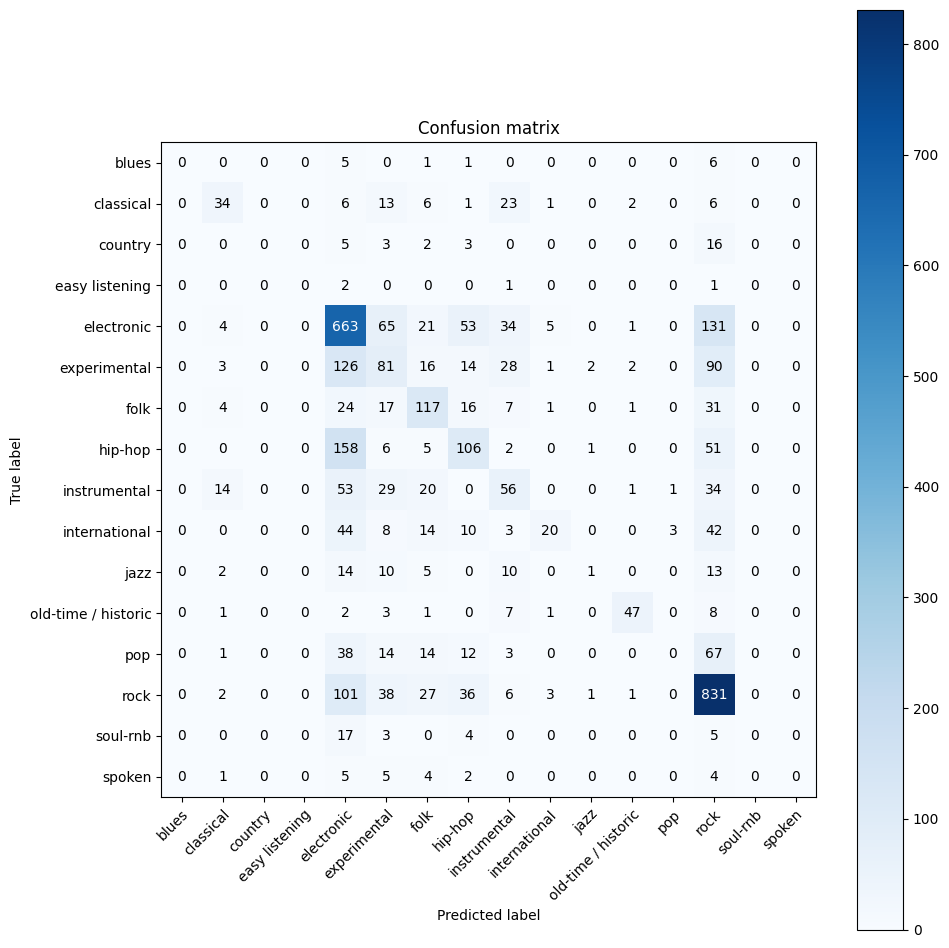

In [38]:
valuate(clf, X_test, y_test)

In [40]:
# best maxdepth
from matplotlib.legend_handler import HandlerLine2D
from typing import Union

def learn_best_max_depth(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_test: pd.DataFrame,
        max_depth_range: Union[list, range, tuple, np.ndarray],
        criterion: str = 'gini',
        splitter: str = 'best',
        title: str = 'Decision Tree',
    ) -> int:
    """
    Learn the best max depth for the decision tree.
    :param X_train: Train features
    :param y_train: Train labels
    :param X_test: Test features
    :param y_test: Test labels
    :param title: Title of the plot
    :param criterion: Criterion
    :param splitter: Splitter
    :return:
    """

    # create lists of scores
    train_results = []
    test_results = []

    # for each max depth
    for max_depth in max_depth_range:

        # create the model
        model = tree.DecisionTreeClassifier(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth
        )

        # train the model
        model.fit(X_train, y_train)

        # compute the accuracy on the train set
        train_results.append(model.score(X_train, y_train))
        test_results.append(model.score(X_test, y_test))


    line1, = plt.plot(max_depth_range, train_results, 'b', label='Train')
    plt.plot(max_depth_range, test_results, 'r', label='Test')
    plt.title(title)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('Tree depth')
    plt.show()

    # find the best max depth
    best_max_depth = max_depth_range[np.argmax(test_results)]
    print(f'Best max depth: {best_max_depth}')
    print(f'Best accuracy: {max(test_results)}')

    return best_max_depth


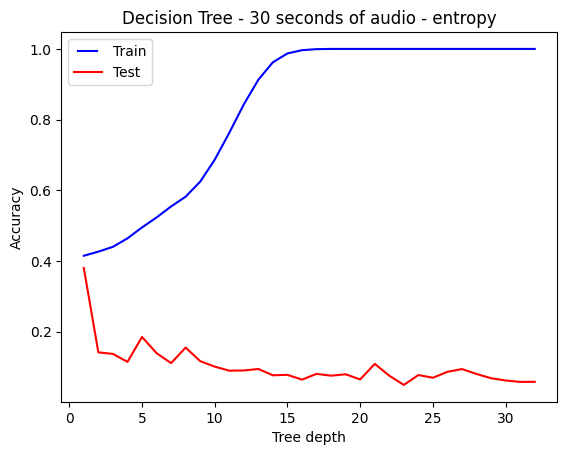

Best max depth: 1
Best accuracy: 0.38003736322391246


In [41]:
max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)

max_depth_30sec = learn_best_max_depth(
    X_train, y_train,
    X_val, y_val,
    max_depths,
    criterion='entropy',
    title='Decision Tree - 30 seconds of audio - entropy',
)


In [42]:
n_estimators = 8
md = 1
classifier = tree.DecisionTreeClassifier(max_depth=md)

clf = BaggingClassifier(classifier,n_estimators=n_estimators)

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 42.70%


In [43]:
n_estimators = 100
clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=3)


clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 46.81%


In [132]:
n_estimators = 8
md = 2
classifier = tree.DecisionTreeClassifier(max_depth=md)
clf = AdaBoostClassifier(classifier,n_estimators=n_estimators)

clf = clf.fit(X_train, y_train)

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)

print('Accuracy: {:.2%}'.format(scores_test))

Accuracy: 42.16%


In [11]:
scores = []
md = 2
r = range(1,30)
for k in r:
    score = cross_val_score(estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth=md),n_estimators=k, algorithm='SAMME'), X=X_train, y=y_train, cv=10, scoring='accuracy')
    scores.append(score.mean())


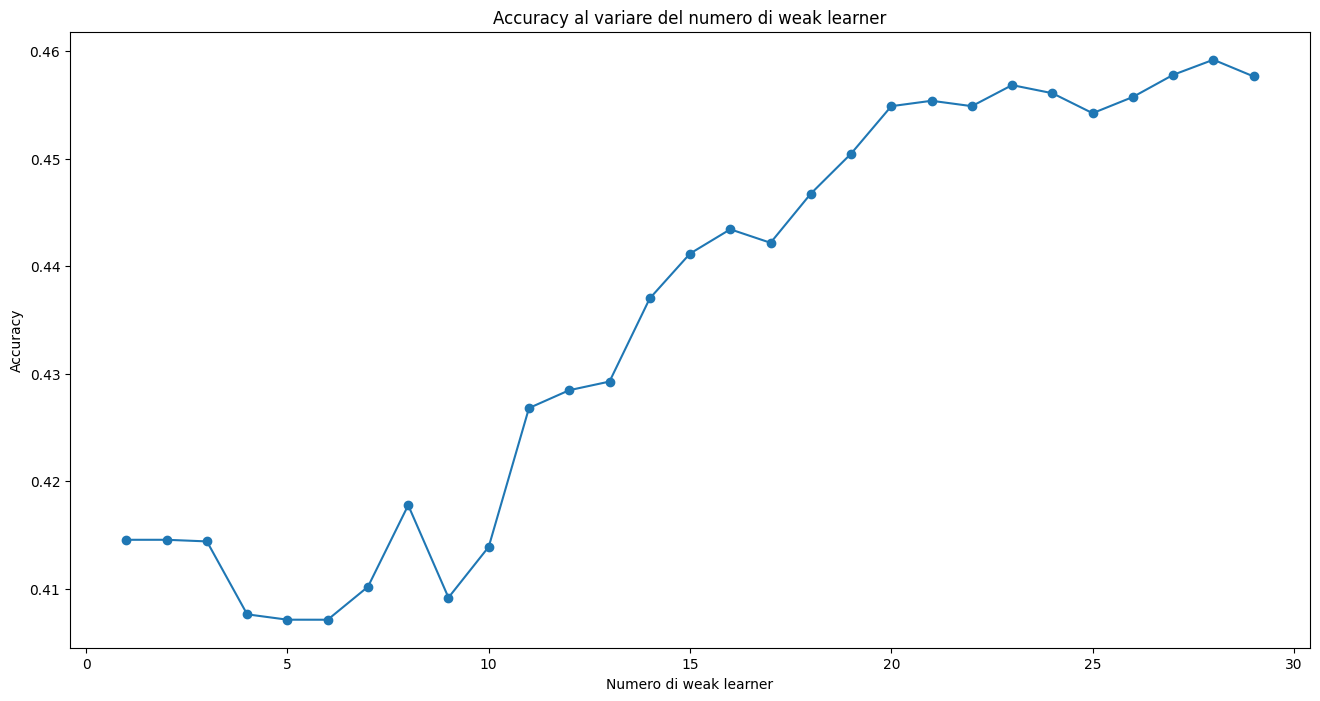

In [12]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(r, scores, marker='o') 
plt.xlabel(r'Numero di weak learner')
plt.ylabel('Accuracy')
plt.title(r'Accuracy al variare del numero di weak learner')
plt.show()


### Multilayer Perceptron

In [44]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [45]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


In [46]:
from torch import nn

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(518, 240)
        self.act = nn.ReLU()
        self.output = nn.Linear(240, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

In [47]:
X_train.values

array([[ 1.71725282,  3.43127085,  0.80688906, ..., -0.52143154,
        -0.98327505,  4.51043768],
       [-0.39415485,  0.17841257,  0.05545573, ..., -0.52143154,
         1.0618112 ,  1.23116543],
       [-0.07481611, -0.10160059, -0.05260795, ..., -0.52143154,
         3.15128376,  0.30135318],
       ...,
       [ 1.58135161,  0.58336929,  0.09564131, ..., -0.12994087,
        -0.17116529,  0.28846993],
       [-0.35308156, -0.52025522, -0.02901715, ...,  0.94665847,
        -0.66656302, -0.55025967],
       [ 0.04643856, -0.44112911, -0.03512316, ...,  3.09985714,
        -0.35157253, -0.68450403]])

In [48]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [49]:
y_train_tensor.shape

torch.Size([17485, 16])

In [50]:
y_train.shape

(17485, 1)

In [51]:
import copy
import tqdm
from torch import optim

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 15
batch_size = 200
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)


Epoch 0: 100%|██████| 87/87 [00:00<00:00, 278.43batch/s, acc=0.685, loss=1.19]


Epoch 0 validation: Cross-entropy=1.17, Accuracy=63.7%


Epoch 1: 100%|██████| 87/87 [00:00<00:00, 293.84batch/s, acc=0.71, loss=0.993]


Epoch 1 validation: Cross-entropy=1.10, Accuracy=65.0%


Epoch 2: 100%|██████| 87/87 [00:00<00:00, 273.71batch/s, acc=0.74, loss=0.878]


Epoch 2 validation: Cross-entropy=1.07, Accuracy=66.2%


Epoch 3: 100%|██████| 87/87 [00:00<00:00, 277.78batch/s, acc=0.77, loss=0.794]


Epoch 3 validation: Cross-entropy=1.06, Accuracy=66.9%


Epoch 4: 100%|██████| 87/87 [00:00<00:00, 281.25batch/s, acc=0.79, loss=0.728]


Epoch 4 validation: Cross-entropy=1.06, Accuracy=67.2%


Epoch 5: 100%|███████| 87/87 [00:00<00:00, 293.99batch/s, acc=0.79, loss=0.67]


Epoch 5 validation: Cross-entropy=1.06, Accuracy=67.4%


Epoch 6: 100%|█████| 87/87 [00:00<00:00, 300.17batch/s, acc=0.815, loss=0.618]


Epoch 6 validation: Cross-entropy=1.07, Accuracy=67.7%


Epoch 7: 100%|██████| 87/87 [00:00<00:00, 294.33batch/s, acc=0.845, loss=0.57]


Epoch 7 validation: Cross-entropy=1.09, Accuracy=67.5%


Epoch 8: 100%|██████| 87/87 [00:00<00:00, 292.33batch/s, acc=0.84, loss=0.523]


Epoch 8 validation: Cross-entropy=1.11, Accuracy=67.4%


Epoch 9: 100%|█████| 87/87 [00:00<00:00, 271.34batch/s, acc=0.845, loss=0.476]


Epoch 9 validation: Cross-entropy=1.13, Accuracy=67.3%


Epoch 10: 100%|█████| 87/87 [00:00<00:00, 291.30batch/s, acc=0.86, loss=0.437]


Epoch 10 validation: Cross-entropy=1.15, Accuracy=66.9%


Epoch 11: 100%|████| 87/87 [00:00<00:00, 271.30batch/s, acc=0.865, loss=0.395]


Epoch 11 validation: Cross-entropy=1.18, Accuracy=67.1%


Epoch 12: 100%|██████| 87/87 [00:00<00:00, 303.56batch/s, acc=0.88, loss=0.36]


Epoch 12 validation: Cross-entropy=1.22, Accuracy=66.6%


Epoch 13: 100%|██████| 87/87 [00:00<00:00, 281.13batch/s, acc=0.9, loss=0.324]


Epoch 13 validation: Cross-entropy=1.25, Accuracy=66.7%


Epoch 14: 100%|██████| 87/87 [00:00<00:00, 283.18batch/s, acc=0.93, loss=0.29]


Epoch 14 validation: Cross-entropy=1.28, Accuracy=66.2%


<All keys matched successfully>

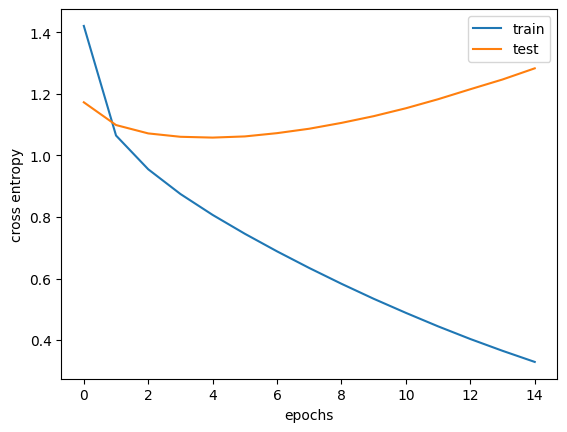

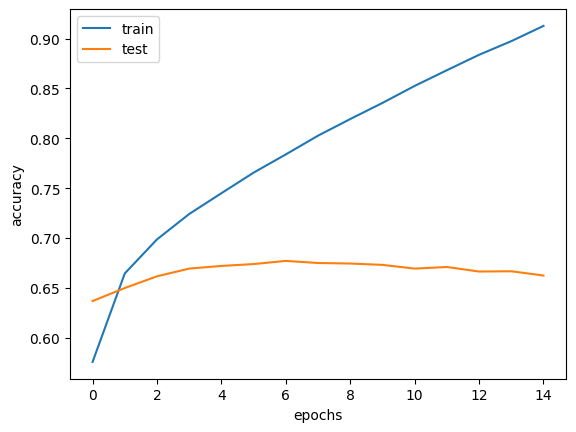

In [52]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [61]:
torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)

tensor([ True,  True, False,  ...,  True, False, False])

### Softmax regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [54]:
scaler = StandardScaler()
logreg = LogisticRegression()

lr_model = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='multinomial')

model = lr_model.fit(X_train, y_train)


In [55]:
y_t = model.predict(X_test)

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        13
          classical       0.68      0.76      0.72        92
            country       0.45      0.34      0.39        29
     easy listening       0.00      0.00      0.00         4
         electronic       0.70      0.76      0.73       977
       experimental       0.47      0.38      0.42       363
               folk       0.58      0.63      0.60       218
            hip-hop       0.64      0.63      0.63       329
       instrumental       0.47      0.40      0.44       208
      international       0.50      0.48      0.49       144
               jazz       0.46      0.42      0.44        55
old-time / historic       0.93      0.97      0.95        70
                pop       0.16      0.10      0.12       149
               rock       0.76      0.83      0.79      1046
           soul-rnb       0.23      0.10      0.14        29
             spoken    

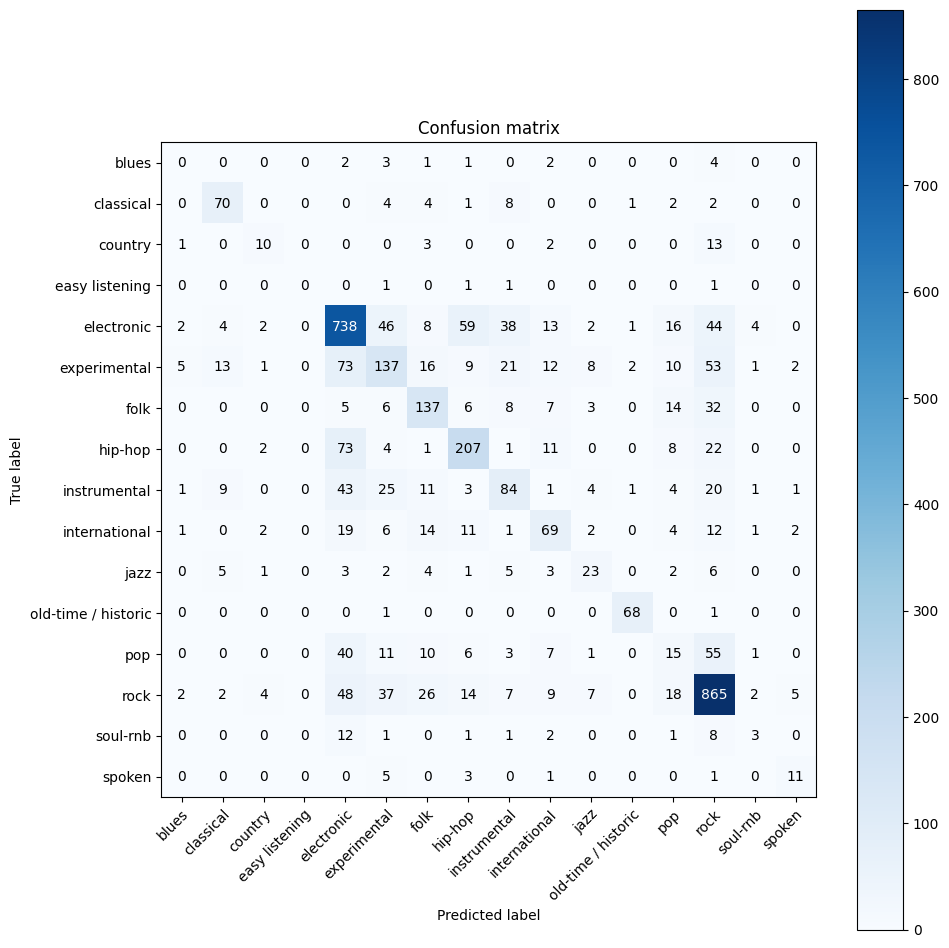

In [56]:
valuate(model, X_test, y_test)

In [51]:
print(accuracy_score(y_t,y_test))

0.6465172137710168


### Gaussian discriminant classifier

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

                     precision    recall  f1-score   support

              blues       0.25      0.15      0.19        13
          classical       0.63      0.70      0.66        92
            country       0.53      0.31      0.39        29
     easy listening       0.00      0.00      0.00         4
         electronic       0.71      0.74      0.73       977
       experimental       0.49      0.38      0.43       363
               folk       0.57      0.61      0.59       218
            hip-hop       0.67      0.66      0.67       329
       instrumental       0.44      0.43      0.43       208
      international       0.56      0.47      0.51       144
               jazz       0.41      0.44      0.42        55
old-time / historic       0.89      0.93      0.91        70
                pop       0.19      0.13      0.16       149
               rock       0.76      0.83      0.80      1046
           soul-rnb       0.31      0.14      0.19        29
             spoken    

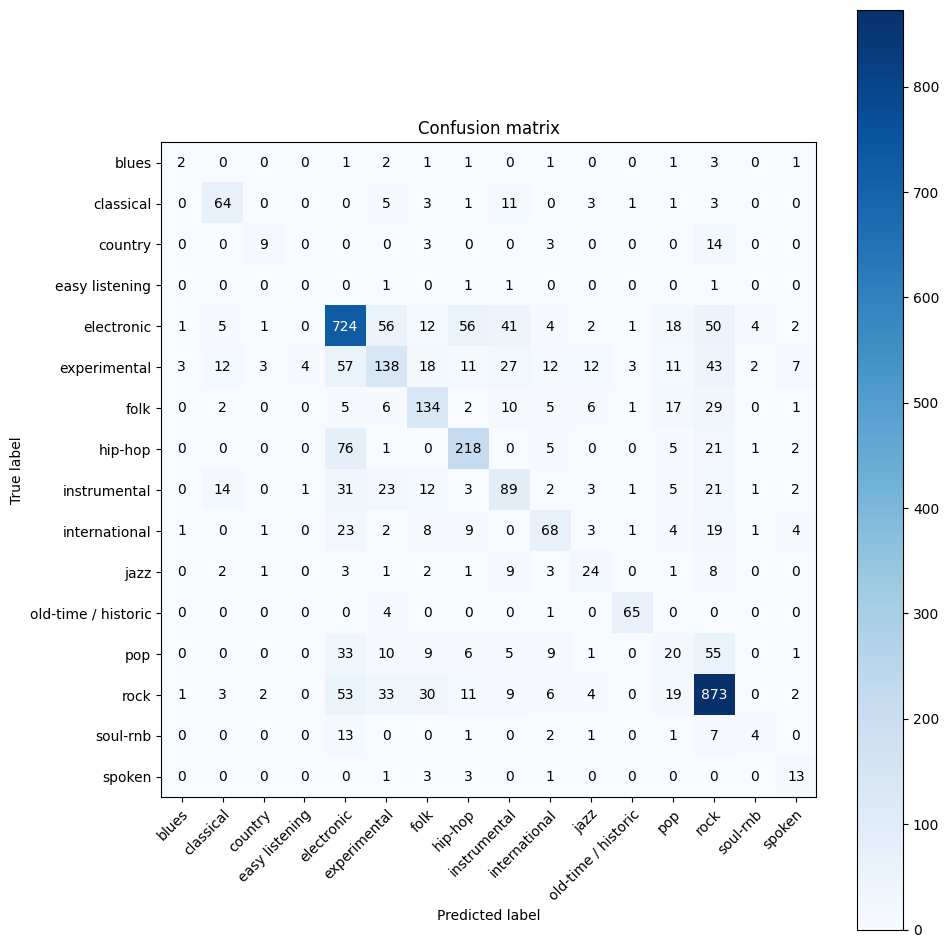

In [58]:
valuate(lda_classifier, X_test, y_test)

### kNN classifier

In [59]:
from sklearn.neighbors import KNeighborsClassifier as KNN

ks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
train_errs = []
test_errs = []
for k in ks:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_errs.append(knn.score(X_train, y_train))
    test_errs.append(knn.score(X_test, y_test))

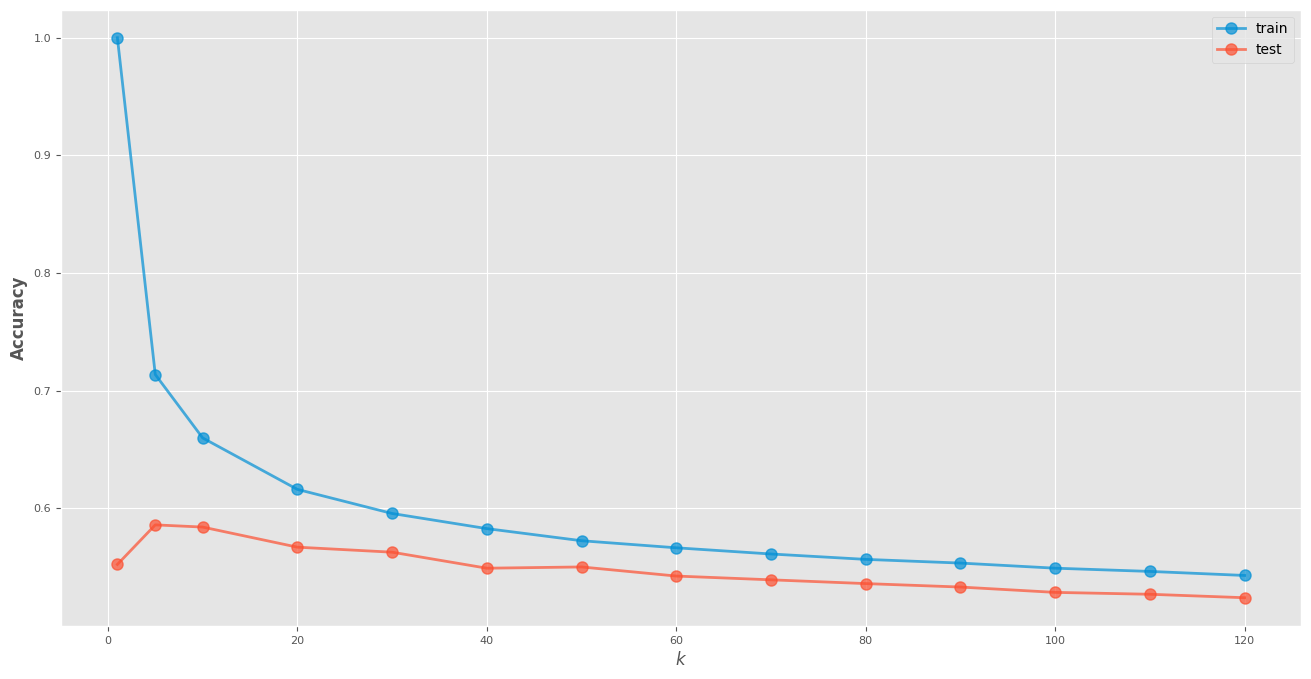

In [60]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])


fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.tick_params(axis='both', which='major', labelsize=8)
ax.plot(ks, train_errs, '-o', color=colors[0], markersize=8, alpha=.7, label='train')
ax.plot(ks, test_errs, '-o', color=colors[1], markersize=8, alpha=.7, label='test')
plt.legend(fontsize=10)
plt.xlabel('$k$', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.show()

## PCA

In [61]:
from sklearn.decomposition import PCA

n_components = 40

print(f"Extracting the top {n_components} eigenfaces from { X_train.shape[0]} songs")
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
pca.explained_variance_

Extracting the top 40 eigenfaces from 17485 songs


array([62.49544459, 39.75532353, 22.2683761 , 16.2867112 , 14.37359477,
       13.19400762, 12.80105955, 12.31446106, 11.42519182,  9.60109481,
        9.06423449,  8.03023132,  7.49056131,  7.32177476,  6.87957287,
        6.29848893,  5.64076811,  5.44601596,  5.05633915,  4.89895611,
        4.58831107,  4.27882896,  4.10452974,  4.03036573,  3.86709447,
        3.74594257,  3.64820125,  3.55986746,  3.47525639,  3.29794807,
        3.07621756,  3.0071944 ,  2.81109272,  2.71651109,  2.66070773,
        2.56315736,  2.50221315,  2.38474836,  2.37000482,  2.23964017])

In [62]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [63]:
print(X_train_pca)

[[-2.00281265  1.26646424  1.27499662 ...  3.43656737  0.07905212
   1.63237093]
 [ 0.12347755  1.61513779  1.12559762 ...  0.44535851 -0.21372655
   0.07743621]
 [-0.69103513 -0.40107211 -0.69737219 ...  0.50672253 -0.62765394
  -0.33276119]
 ...
 [-0.55937006  0.34277692  0.05232498 ... -0.15554287  0.01114122
   1.02456944]
 [-0.0749478  -0.52093978 -0.11901315 ... -0.31757459 -0.9439131
  -0.35788143]
 [ 0.5973411  -1.09296298  1.73245265 ... -0.6116382  -0.37193846
   0.03998497]]


In [64]:
# Support vector classification.
clf = skl.svm.SVC(kernel="rbf")
clf.fit(X_train_pca, y_train)


SVC()

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        13
          classical       0.75      0.65      0.70        92
            country       0.00      0.00      0.00        29
     easy listening       0.00      0.00      0.00         4
         electronic       0.64      0.81      0.71       977
       experimental       0.47      0.45      0.46       363
               folk       0.60      0.62      0.61       218
            hip-hop       0.66      0.52      0.58       329
       instrumental       0.50      0.35      0.41       208
      international       0.63      0.36      0.46       144
               jazz       0.54      0.24      0.33        55
old-time / historic       0.92      0.94      0.93        70
                pop       0.20      0.02      0.04       149
               rock       0.72      0.85      0.78      1046
           soul-rnb       0.00      0.00      0.00        29
             spoken    

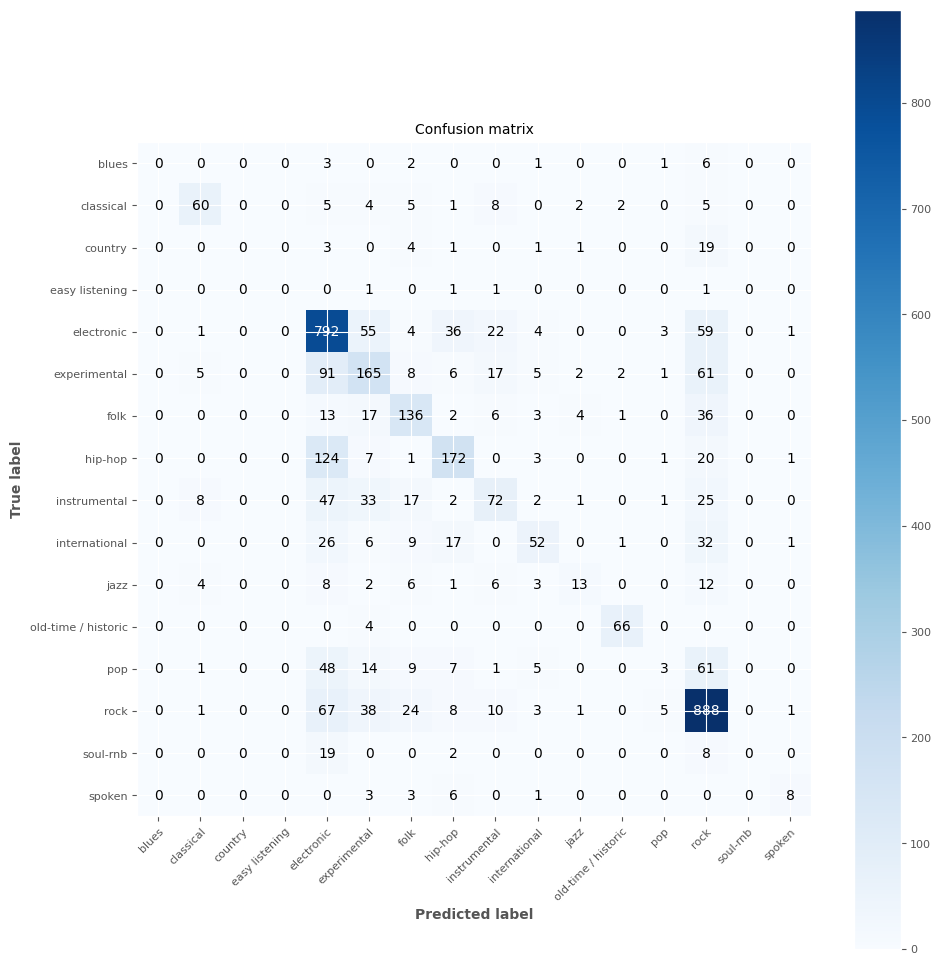

In [65]:
valuate(clf, X_test_pca, y_test)

In [66]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X_train.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:80]


print("Varianza spiegata da ciascuna componente:", pca_feature_importance)
print("Varianza totale spiegata:", np.sum(pca.explained_variance_ratio_))

ValueError: too many values to unpack (expected 3)

In [67]:
y_test.to_numpy()

array([['international'],
       ['pop'],
       ['rock'],
       ...,
       ['electronic'],
       ['rock'],
       ['electronic']], dtype=object)

In [68]:
for x in X_test_pca:

    # Query point (choose any test point)
    x_query = X_test_pca[0].reshape(1, -1)  # Reshape to match training dimension

    # Compute weights using Gaussian kernel
    tau = 0.5  # Bandwidth parameter
    distances = np.linalg.norm(X_train_pca - x_query, axis=1) ** 2
    weights = np.exp(-distances / (2 * tau**2))  # Gaussian weighting

    # Train weighted softmax regression
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    model.fit(X_train_pca, y_train, sample_weight=weights)

    # Predict on test set
    y_pred = model.predict(X_test_pca)

    # Accuracy
    accuracy = np.mean(y_pred == y_test.to_numpy())
    print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04
Accuracy: 0.04


KeyboardInterrupt: 